<a href="https://colab.research.google.com/github/Tuan-Lee-23/Deep-learning-with-Pytorch/blob/main/How%20to%20fine-tune%20BERT%20with%20Pytorch%20Lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install libs

In [ ]:
!pip install --quiet transformers datasets wandb  pytorch-lightning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

drive  sample_data


In [ ]:
%cd drive/MyDrive/BERT/finetuning/ 

/content/drive/MyDrive/BERT/finetuning


# Load Libs

In [ ]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import AdamW
from transformers import get_scheduler

from torch.utils.data import DataLoader
import torch
from torch.nn import functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import torchmetrics
from pytorch_lightning.loggers import WandbLogger

from tqdm.auto import tqdm
from datasets import load_dataset

In [ ]:
!nvidia-smi

Fri Dec 10 12:43:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Datasets

In [ ]:
imdb = load_dataset("imdb")

Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
imdb['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

# Hyperparameters

In [ ]:
gpus = 1
progress_bar_refresh_rate = 30
val_check_interval = 0.33 # check val set 3 times during a training epoch

max_seq_len = 128
batch_size = 32
lr = 2e-6
max_epochs= 5
weight_decay = 0.2

# Preprocessing

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
sentences = "Hello bro"
inputs = tokenizer(sentences, truncation=True, max_length = max_seq_len)
inputs

{'input_ids': [101, 7592, 22953, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], max_length = max_seq_len, truncation=True, padding = 'max_length')

tokenized_datasets = imdb.map(tokenize_function, batched=True)
tokenized_datasets

Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-578a14ab98727454.arrow


  0%|          | 0/25 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-fbcb705eb6973c9c.arrow


DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
        num_rows: 50000
    })
})

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
print(tokenized_datasets)
tokenized_datasets.set_format("torch")

# small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
# small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(10000))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(10000, 25000))

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-e201d40829b3f0f5.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-8d05020670948a7d.arrow


DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 50000
    })
})


In [ ]:
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size= batch_size, num_workers=2)
eval_dataloader = DataLoader(small_eval_dataset, batch_size= batch_size, num_workers = 2)
test_dataloader = DataLoader(small_test_dataset, batch_size= batch_size, num_workers = 2)

# Model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
print(model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
try:
    wandb.finish()
except:
    pass

wandb_logger = WandbLogger(project="Finetuning")

class IMDBClassifier(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

    self.train_acc = torchmetrics.Accuracy()
    self.val_acc = torchmetrics.Accuracy()
    self.test_acc = torchmetrics.Accuracy()


  def forward(self, input_ids, attention_mask, labels = None):
      output = self.model(
          input_ids = input_ids,
          attention_mask = attention_mask,
          labels = labels
      )
      return output.loss, output.logits

  def cross_entropy_loss(self, logits, labels):
    return F.nll_loss(logits, labels)

  def training_step(self, batch, batch_idx):
      input_ids = batch['input_ids']
      attention_mask = batch['attention_mask']
      labels = batch['labels']
      loss, output = self(input_ids, attention_mask, labels)

      # this will reset the metric automatically at the epoch end
      acc = self.train_acc(output, labels)
      self.log("train/loss", loss)
      self.log("train/acc", acc)


      return loss


  def validation_step(self, batch, batch_idx):
      input_ids = batch['input_ids']
      attention_mask = batch['attention_mask']
      labels = batch['labels']
      loss, output = self(input_ids, attention_mask, labels)


    # this will reset the metric automatically at the epoch end
      acc = self.val_acc(output, labels)

      self.log("val/loss", loss)
      self.log("val/acc", acc)


      return loss

  def test_step(self, batch, batch_idx):
      input_ids = batch['input_ids']
      attention_mask = batch['attention_mask']
      labels = batch['labels']
      loss, output = self(input_ids, attention_mask, labels)

    # this will reset the metric automatically at the epoch end
      acc = self.test_acc(output, labels)
      self.log("test/loss", loss)
      self.log("test/acc", acc)

      return loss, acc

  def configure_optimizers(self):
    optimizer = AdamW(self.model.parameters(), lr=lr, betas = (0.9, 0.999), weight_decay = weight_decay)    
    return optimizer

  def optimizer_zero_grad(self, epoch, batch_idx, optimizer, optimizer_idx):
    optimizer.zero_grad(set_to_none=True)

model = IMDBClassifier()
checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filename = 'best-checkpoint-{epoch:02d}-{val_acc:.2f}',
    save_top_k = 1,
    every_n_epochs = 1,
    verbose = True,
    monitor = 'val_loss',
    mode = "min"
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
trainer = pl.Trainer(
    checkpoint_callback = checkpoint_callback,
    max_epochs= max_epochs, 
    gpus = gpus, 
    progress_bar_refresh_rate = progress_bar_refresh_rate,
    logger=wandb_logger, 
    val_check_interval = val_check_interval)

trainer.fit(model, train_dataloader, eval_dataloader)
trainer.test(model, test_dataloader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f365db6a450>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f365db6a450>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Tr


  | Name      | Type                          | Params
------------------------------------------------------------
0 | model     | BertForSequenceClassification | 109 M 
1 | train_acc | Accuracy                      | 0     
2 | val_acc   | Accuracy                      | 0     
3 | test_acc  | Accuracy                      | 0     
------------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.935   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
# %cd Finetuning/1yd24hy7/checkpoints/

In [ ]:
# # test (pass in the loader)
# model = IMDBClassifier.load_from_checkpoint('epoch=3-step=1559.ckpt')
# trainer = pl.Trainer(
#     # checkpoint_callback = checkpoint_callback,
#     # max_epochs= max_epochs, 
#     gpus = gpus)

# # trainer.fit(model, train_dataloader, eval_dataloader)
# trainer.test(model, dataloaders=test_dataloader)

# Results

## Model 1 
- batch size: 64
- lr: 2e-5
- weight decay: 0.01
- test accuracy: 0.8718

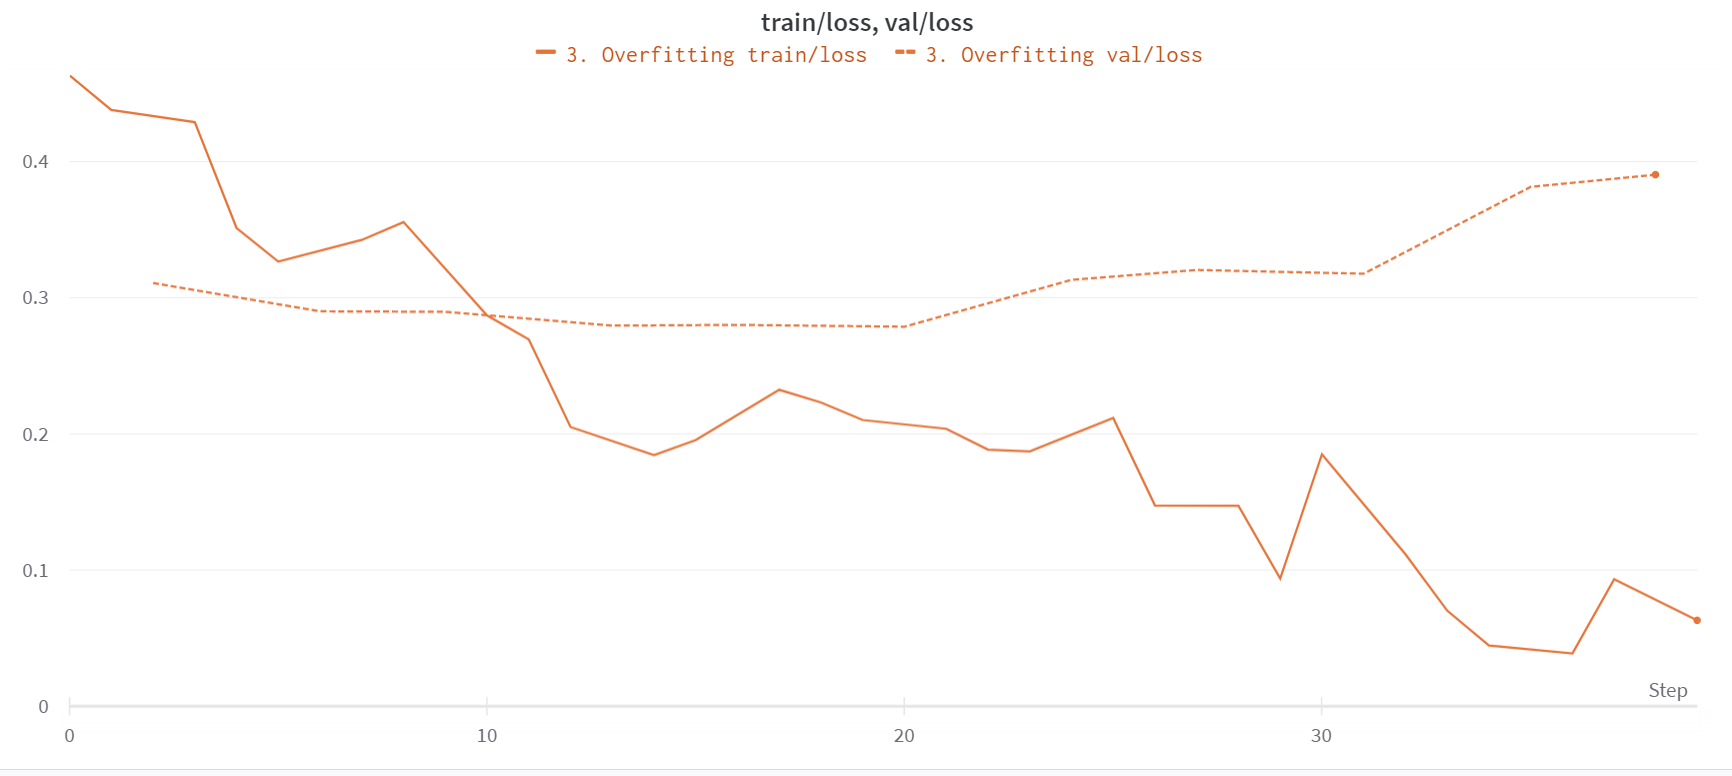

## Model 2 
- batch size: 64
- lr: 2e-6
- weight decay: 0.3
- test accuracy: 0.664 (epoch 3)

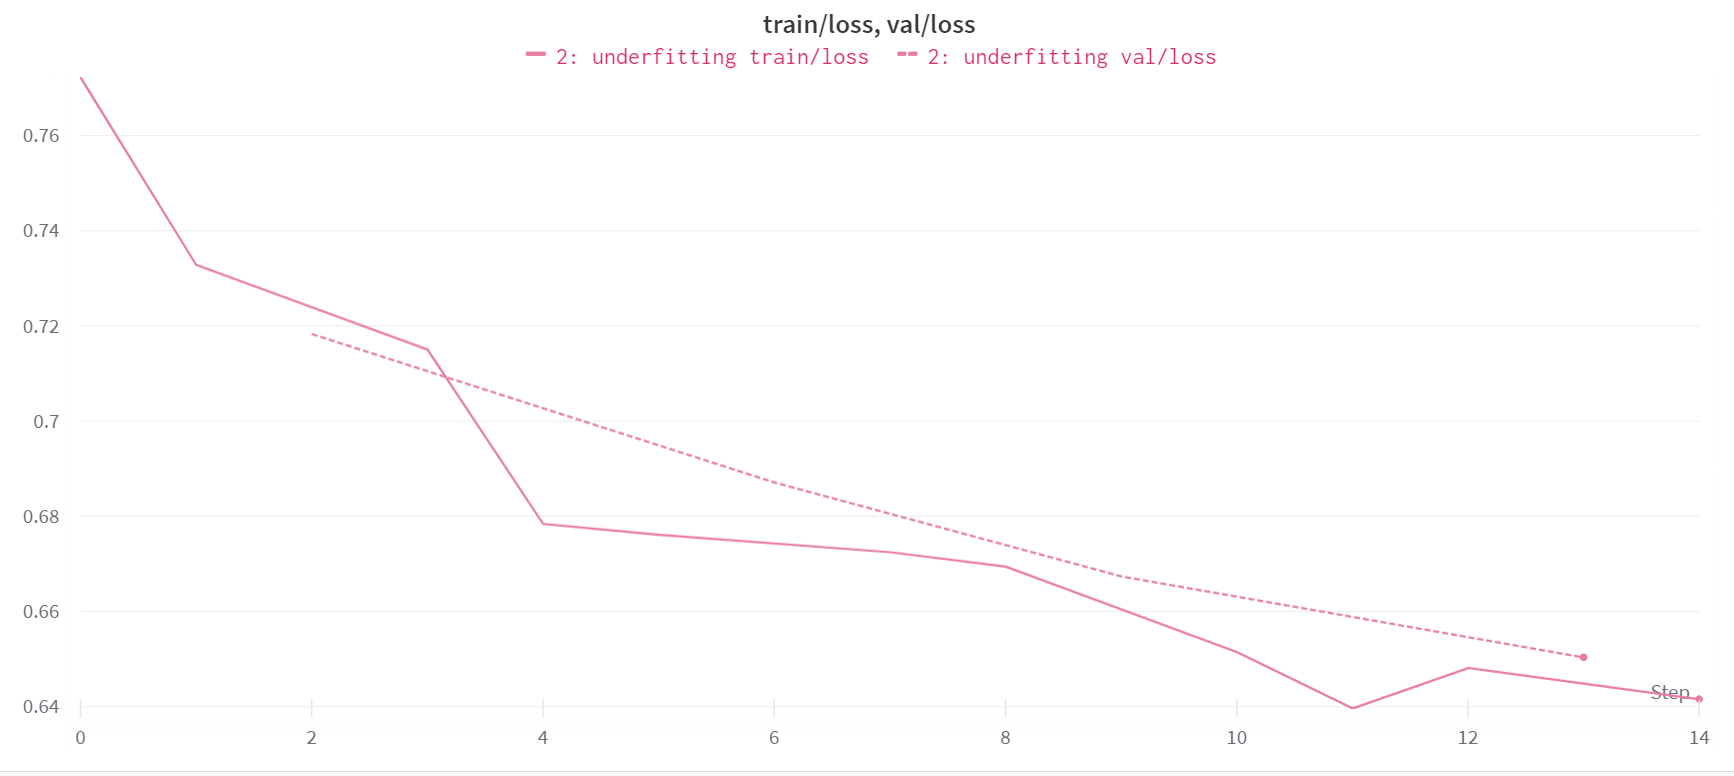

## Model 3
- batch size: 32
- lr: 2e-6
- weight decay: 0.2
- test accuracy: 0.887

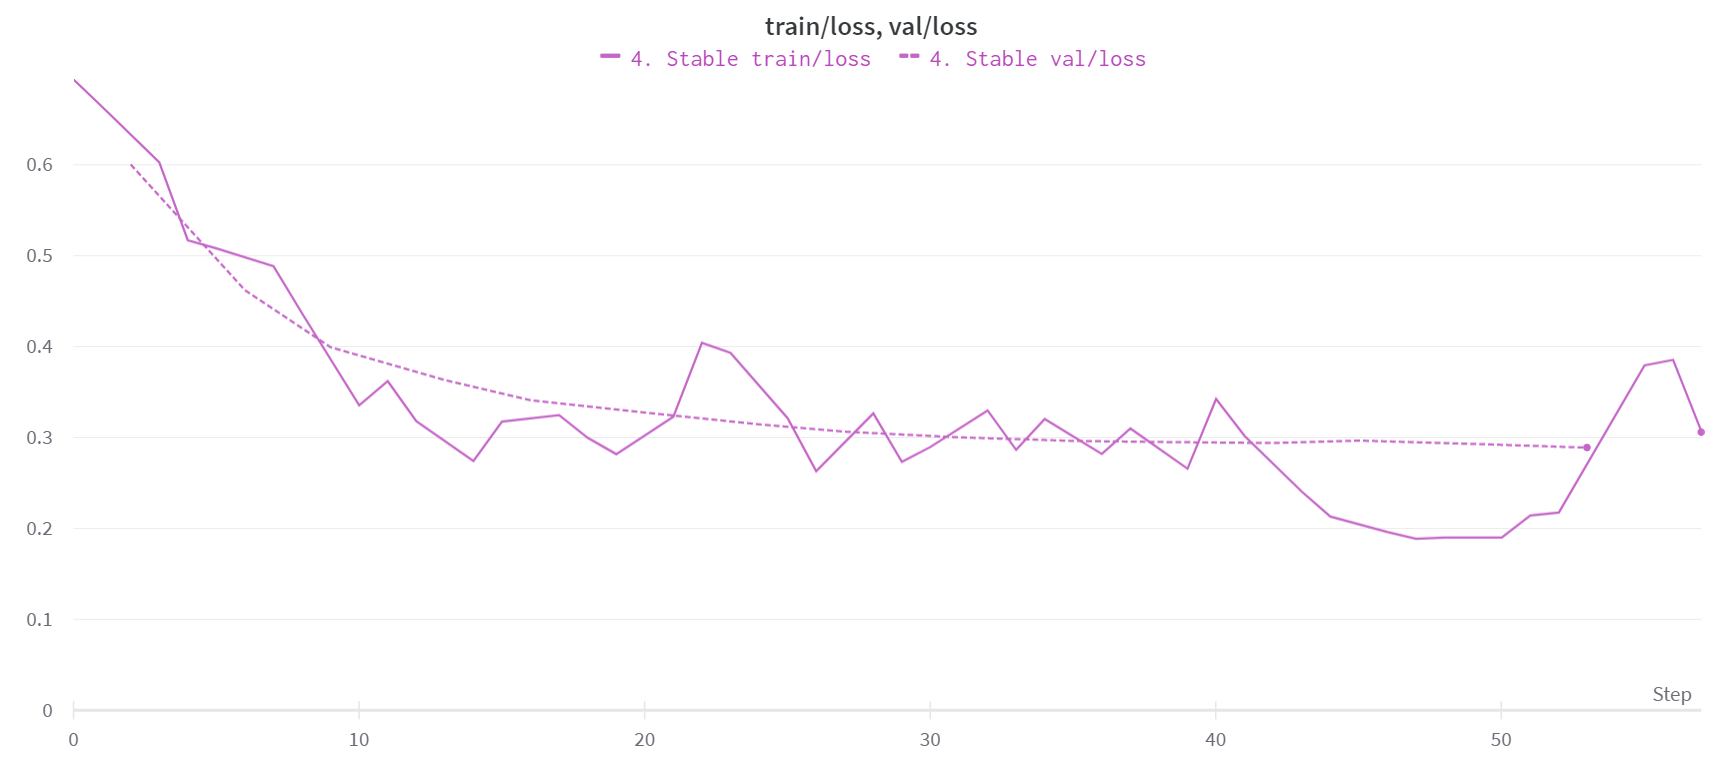

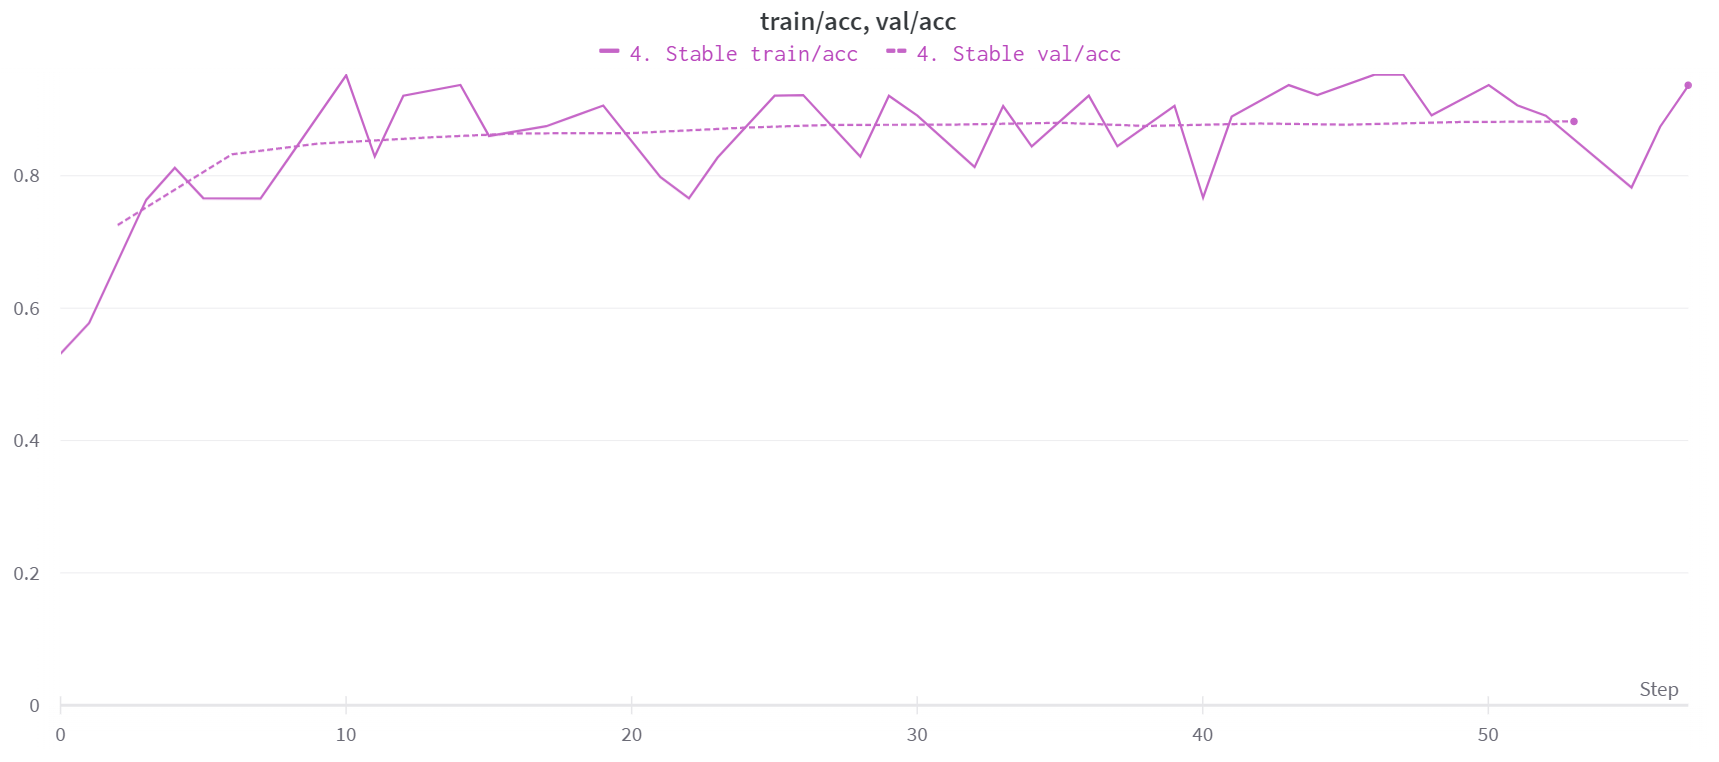

## Improvement
- Early stopping
- Warmup step - lr scheduler
- max_seq_len
- 16-bit Precision
- Further pretraining
- Variants: 
  - RoBERTa
  - XLNET
  - DistilBert